In [1]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [106]:
data1 = pd.read_csv("data/train.csv",sep=',')
data2 = pd.read_csv("data/test.csv",sep=',')
train = pd.concat([data1, data2], ignore_index=True)

 ## Visualizacao basica dos dados

In [107]:
train.head(5)

Id  area_extra  area_util        bairro  churrasqueira  \
0  2000         167        223   Imbiribeira              0   
1  2001           0        157  Casa Amarela              1   
2  2002           0         53  Encruzilhada              0   
3  2003           0        149    Boa Viagem              1   
4  2004           0         54     Rosarinho              1   

              diferenciais  estacionamento  piscina  playground      preco  \
0           piscina e copa               0        1           0  1000000.0   
1  piscina e churrasqueira               0        1           0   680000.0   
2                   nenhum               0        0           0   450000.0   
3  piscina e churrasqueira               0        1           0  1080000.0   
4  piscina e churrasqueira               0        1           0   350000.0   

     ...      quartos  s_festas  s_ginastica  s_jogos  sauna  suites  \
0    ...            3         0            0        0      0       3   
1    ...            4         0            0        0      0       4   
2    ...            3         0            0        0      0       1   
3    ...            4         0            0        0      0       3   
4    ...            2         0            0        0      0       1   

          tipo tipo_vendedor vagas  vista_mar  
0         Casa   Imobiliaria     5          0  
1  Apartamento   Imobiliaria     2          0  
2  Apartamento   Imobiliaria     0          0  
3  Apartamento   Imobiliaria     2          0  
4  Apartamento   Imobiliaria     1          0  

[5 rows x 21 columns]

### Verificacao de outliers

6683 linhas no dataset


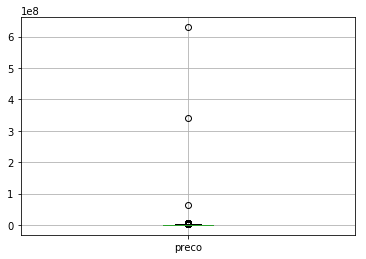

In [169]:
train.boxplot(column = ['preco'])
print("{} linhas no dataset".format(len(train.preco)))

In [170]:
train_without_outliers = train[np.abs(train.preco - train.preco.mean()) <= ( 2 * train.preco.std())]
train_without_outliers.boxplot(column = ['preco'])
print("{} linhas no dataset".format(len(train_without_outliers.preco)))

4680 linhas no dataset


### One hot encoding

In [171]:
non_discrete_categorical_columns = ['area_util','area_extra']
discrete_categorical_columns = ['quartos','suites','vagas']
binary_columns = ['estacionamento','piscina','playground','quadra','s_festas','s_jogos','s_ginastica','s_ginastica','sauna','vista_mar']


one_hot_data = train_without_outliers.copy()

hot_columns = pd.get_dummies(one_hot_data['tipo'], prefix= 'tipo')
one_hot_data = pd.concat([one_hot_data, hot_columns], axis=1)
one_hot_data = one_hot_data.drop(columns=['tipo'])

for column in discrete_categorical_columns:   
    hot_columns = pd.get_dummies(one_hot_data[column], prefix= column)
    one_hot_data = pd.concat([one_hot_data, hot_columns], axis=1)
    one_hot_data = one_hot_data.drop(columns=[column])

df = one_hot_data.drop(columns=['Id','diferenciais','tipo_vendedor'])
df.head(3)

area_extra  area_util        bairro  churrasqueira  estacionamento  \
0         167        223   Imbiribeira              0               0   
1           0        157  Casa Amarela              1               0   
2           0         53  Encruzilhada              0               0   

   piscina  playground      preco  quadra  s_festas    ...     vagas_7  \
0        1           0  1000000.0       0         0    ...           0   
1        1           0   680000.0       0         0    ...           0   
2        0           0   450000.0       0         0    ...           0   

   vagas_8  vagas_10  vagas_12  vagas_13  vagas_15  vagas_17  vagas_18  \
0        0         0         0         0         0         0         0   
1        0         0         0         0         0         0         0   
2        0         0         0         0         0         0         0   

   vagas_20  vagas_30  
0         0         0  
1         0         0  
2         0         0  

[3 rows x 51 columns]

In [172]:
renda_bairros = pd.read_csv("data/renda_bairros.csv",sep=',')
renda_bairros.iloc[:,2:] = renda_bairros.iloc[:,1:].fillna(0)
renda_bairros.iloc[:, 2:] = renda_bairros.iloc[:, 2:].divide(renda_bairros.iloc[:,1], axis = 'rows')
renda_bairros = renda_bairros.drop(columns=['Total ¹'])
renda_bairros.head(3)

bairro  Até 1/2 salário mínimo  Mais de 1/2 a 1 salário mínimo  \
0    Aflitos                0.002581                        0.012390   
1   Afogados                0.036308                        0.194274   
2  Agua Fria                0.055393                        0.219538   

   Mais de 1 a 2 salários mínimos  Mais de 2 a 5 salários mínimos  \
0                        0.026846                        0.094476   
1                        0.253974                        0.301842   
2                        0.296974                        0.285993   

   Mais de 5 a 10 salários mínimos  Mais de 10 a 20 salários mínimos  \
0                         0.223542                          0.308725   
1                         0.114884                          0.033779   
2                         0.070360                          0.013584   

   Mais de 20 salários mínimos  Sem rendimento  
0                     0.273619        0.057821  
1                     0.006954        0.057984  
2                     0.002603        0.055556

In [198]:
woth_column_names = ['meio_salario','meio_1_salario','1_2_salarios','2_5_salarios','5_10_salarios','10_20_salarios','20_salarios','sem_salario']
df_with_income = pd.concat([df,df.reindex(columns = woth_column_names)], axis = 1)

all_neighborhood = list(df_with_income.bairro.unique())
skip_neighborhood = ['Beira Rio', 'Centro']
neighborhood = list(set(all_neighborhood).symmetric_difference(skip_neighborhood))

df_with_income.loc[df_with_income.bairro == 'Beira Rio', woth_column_names] = 1/len(woth_column_names)
df_with_income.loc[df_with_income.bairro == 'Centro', woth_column_names] = 1/len(woth_column_names)

for neighborhood_name in neighborhood:
        df_with_income.loc[df.bairro == neighborhood_name, woth_column_names] = renda_bairros[renda_bairros['bairro'] == bairro].iloc[:,1:].values

df_with_income = df_with_income.drop(columns=['bairro'])
df_with_income.head(3)

area_extra  area_util  churrasqueira  estacionamento  piscina  playground  \
0         167        223              0               0        1           0   
1           0        157              1               0        1           0   
2           0         53              0               0        0           0   

       preco  quadra  s_festas  s_ginastica     ...       vagas_20  vagas_30  \
0  1000000.0       0         0            0     ...              0         0   
1   680000.0       0         0            0     ...              0         0   
2   450000.0       0         0            0     ...              0         0   

   meio_salario  meio_1_salario  1_2_salarios  2_5_salarios  5_10_salarios  \
0      0.036308        0.194274      0.253974      0.301842       0.114884   
1      0.036308        0.194274      0.253974      0.301842       0.114884   
2      0.036308        0.194274      0.253974      0.301842       0.114884   

   10_20_salarios  20_salarios  sem_salario  
0        0.033779     0.006954     0.057984  
1        0.033779     0.006954     0.057984  
2        0.033779     0.006954     0.057984  

[3 rows x 58 columns]

In [196]:
df_normalized['vista_mar'] = df_normalized['vista_mar'] * 2

In [249]:
data = {}

# basic dataset

simple_df = df.copy()
hot_columns = pd.get_dummies(simple_df['bairro'], prefix= 'b')
simple_df = pd.concat([simple_df, hot_columns], axis=1)
simple_df = simple_df.copy().drop(columns=['bairro'])


b_target = simple_df['preco']
b_parameters= simple_df.copy().drop(columns=['preco'])

data['basic'] = {"parameter": b_parameters, "target": b_target}

# basic dataset normalized (all columns)

simple_df_normalized = simple_df.copy()
x = simple_df_normalized.values 
min_max_scaler = preprocessing.MinMaxScaler()
simple_df_normalized = pd.DataFrame(min_max_scaler.fit_transform(simple_df_normalized), columns = simple_df_normalized.columns, index= simple_df_normalized.index)

bn_target = simple_df_normalized['preco']
bn_paramaters = simple_df_normalized.copy().drop(columns=['preco'])

data['basic_normalized'] = {"parameter": bn_paramaters, "target": bn_target}

# dataset with neighborhood info

target_ninfo = df_with_income['preco']
paramaters_ninfo = df_with_income.copy().drop(columns=['preco'])

data['neighborhood'] = {"parameter": paramaters_ninfo, "target": target_ninfo}

# dataset with neighborhood info normalized

df_normalized = df_with_income.copy()
x = df_normalized.values 
min_max_scaler = preprocessing.MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_normalized), columns= df_normalized.columns, index= df_normalized.index)

target_ninfo_n = df_normalized['preco']
paramaters_ninfo_n = df_normalized.copy().drop(columns=['preco'])

data['neighborhood_normalized'] = {"parameter": paramaters_ninfo_n, "target": target_ninfo_n}



## Modelos

In [339]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

In [331]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

def rmspe(y_pred, y):
    rmspe = np.sqrt(np.mean( (1/ y**2) * (y_pred - y)**2 ))
    return rmspe

rmspe_score = make_scorer(rmspe, greater_is_better=False)

def testMultipleDatasetPerformance(model, data_dict, cross_valitations = 5):
    results = {}   
    for dataset in list(data_dict.items()):
        name = dataset[0]
        data = dataset[1]
        print('testing model: ', name)
        scores = cross_val_score(model,
                                 data['parameter'],
                                 data['target'],
                                 scoring = rmspe_score,
                                 cv= cross_valitations)
        # for some reason cross_val_score puts a negative sign in the score, so we nedd to negative it again
        results[name] = -np.mean(scores)
    return results

In [ ]:

kRidg = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

lasso = Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

result = testMultipleDatasetPerformance(lasso, data, 5)
result